# MNIST Classification with Softmax Regression and FCNN
This notebook implements a Softmax regression model and a Fully Connected Neural Network to classify handwritten digits from the MNIST dataset.

## Dataset Overview
The MNIST dataset contains 70,000 grayscale images of handwritten digits (0-9), split into 60,000 training and 10,000 test images. Each image is 28x28 pixels.
The data is concatenated and split into train:validate:test with ratio 0.6:0.2:0.2 respectively.

# Data Loading and Preprocessing

In [1]:
import torch
import numpy as np
import pandas as pd
from PIL import Image
import codecs
import matplotlib.pyplot as plt
import math

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

# copy the downloaded dataset to the current directory
import shutil
shutil.copytree(path, "dataset", dirs_exist_ok=True)


Path to dataset files: /kaggle/input/mnist-dataset


'dataset'

### Data Reading Utilities 

* Custom functions to read MNIST's binary file formats
* `get_int()`: Converts binary data to integers
* `read_label_file()`: Extracts label data
* `read_image_file()`: Extracts image data with proper reshaping
     

In [3]:
def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

def read_label_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2049
        length = get_int(data[4:8])
        parsed = np.frombuffer(data, dtype=np.uint8, offset=8)
        return np.array(parsed, dtype=np.uint8).reshape(length)


def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2051
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        parsed = np.frombuffer(data, dtype=np.uint8, offset=16)
        return np.array(parsed, dtype=np.uint8).reshape((length,num_rows,num_cols))

### Data Loading

In [4]:
train_images = read_image_file('dataset/train-images.idx3-ubyte')
train_labels = read_label_file('dataset/train-labels.idx1-ubyte')
test_images = read_image_file('dataset/t10k-images.idx3-ubyte')
test_labels = read_label_file('dataset/t10k-labels.idx1-ubyte')

print(train_images.shape, train_labels.shape)

(60000, 28, 28) (60000,)


In [5]:
# concat train and test
images = np.concatenate([train_images, test_images])
labels = np.concatenate([train_labels, test_labels])

### Train-Validation-Test Split 

* Uses scikit-learn's train_test_split
* Creates training set, validation set, test set
         

In [6]:
from sklearn.model_selection import train_test_split
train_test_images, val_images, train_test_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
train_images, test_images, train_labels, test_labels = train_test_split(train_test_images, train_test_labels, test_size=0.2, random_state=42)

In [7]:
print(train_images.shape, train_labels.shape)

(44800, 28, 28) (44800,)


## Data Preprocessing

### Custom Dataset Class
* Create a PyTorch Dataset class for MNIST
* Implement `__init__`, `__getitem__`, and `__len__` methods
* Add image transformations

In [8]:
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Normalize

In [9]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels, image_transform:Compose = None):
        self.images = images
        self.labels = labels
        self.image_transform = image_transform

    def __getitem__(self, index: int):
        image, label = self.images[index], self.labels[index]
        image = Image.fromarray(image, mode='L')
        if self.image_transform is not None:
            image = self.image_transform(image)
            
        return image, label
        
    def __len__(self):
        return len(self.images)

### Image Transformations 

* Define transformation pipelines using Compose
* Include:
    * ToTensor conversion
    * Normalization
    * Optional augmentations for training RandomAffine,GaussianBlur,etc.
         
     

In [10]:
image_transform = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
])

In [11]:
from torchvision.transforms import (
    RandomAffine,
    GaussianBlur,
    ElasticTransform
)

image_augmentation_transform = Compose([
    ToTensor(),
    RandomAffine(
        degrees=7.5,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=5,
    ),
    GaussianBlur(kernel_size=3, sigma=(0.1, 0.2)),
    ElasticTransform(alpha=37.0, sigma=5.0),
    Normalize((0.1307,), (0.3081,))
])

In [12]:
train_dataset = MNISTDataset(train_images, train_labels, image_transform)
train_augmented_dataset = MNISTDataset(train_images, train_labels, image_augmentation_transform)
val_dataset = MNISTDataset(val_images, val_labels, image_transform)
test_dataset = MNISTDataset(test_images, test_labels, image_transform)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=64, num_workers=4, prefetch_factor=2, shuffle=True)
train_augmented_loader = DataLoader(train_augmented_dataset, batch_size=64, num_workers=4, prefetch_factor=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=4, prefetch_factor=2)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=4, prefetch_factor=2)

In [14]:
def visualize_batch(loader):
    batch_images, batch_labels = next(iter(loader))
    print(batch_images.size(), batch_labels.size())
    batch_size = batch_images.size(0)
    cols = math.ceil(math.sqrt(batch_size))
    rows = math.ceil(batch_size / cols)
    # Create a grid of images
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i, (image, label) in enumerate(zip(batch_images, batch_labels)):
        ax = axes[i//rows, i%cols]
        # Convert tensor back to image for display
        ax.imshow(image.squeeze(), cmap='gray')
        ax.axis('off')
        ax.set_title(f'Label: {label.item()}')
    plt.tight_layout()
    plt.show()

torch.Size([64, 1, 28, 28]) torch.Size([64])


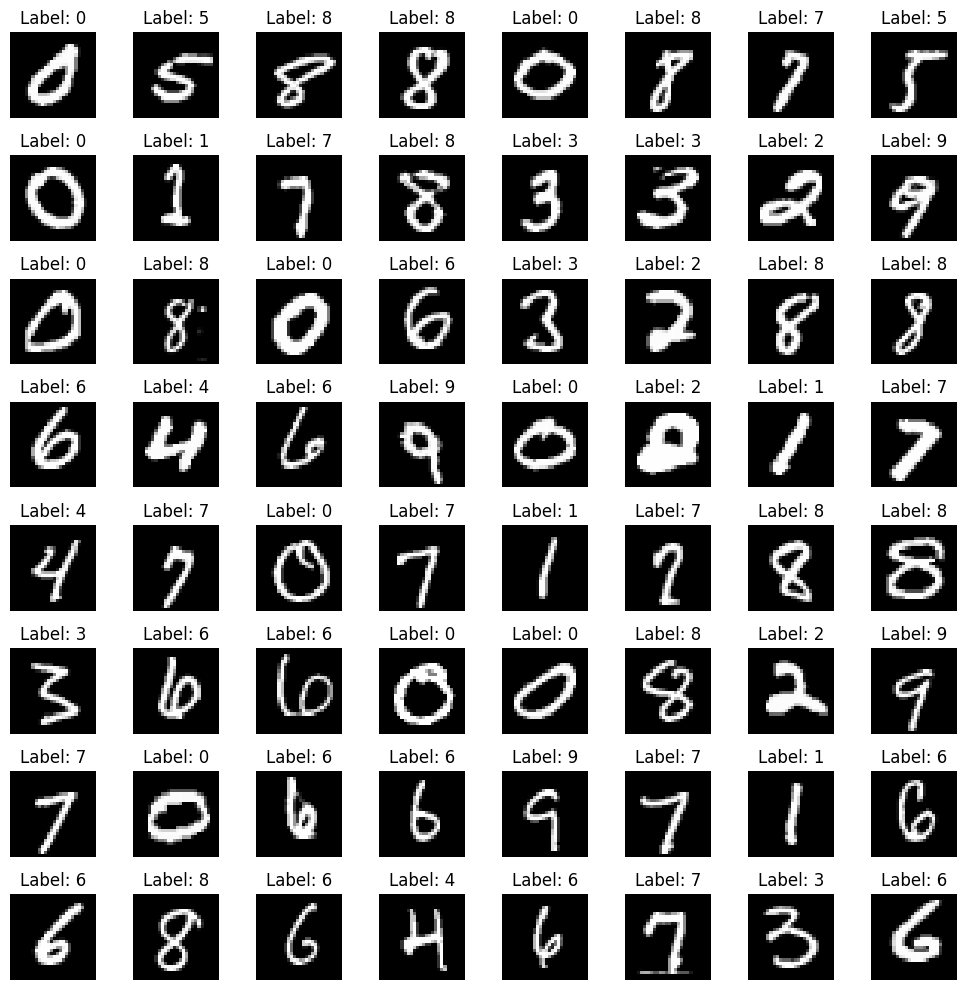

In [15]:
visualize_batch(train_loader)

# Training

## Training Configuration
* Create a dataclass for experiment configuration
* Include hyperparameters:
    * Learning rates
    * Batch sizes
    * Dropout rates
    * Optimization algorithms
    * Scheduling strategies

In [16]:
from dataclasses import dataclass, field
from typing import List

@dataclass
class TrainingConfig:
    # Model parameters
    input_size: int = 28 * 28
    output_size: int = 10
    hidden_sizes: List[int] = field(default_factory=lambda: [])  # Empty by default for softmax
    dropout_rate: float = 0.0
    
    # Training parameters
    batch_size: int = 128
    num_epochs: int = 50
    learning_rate: float = 0.01
    weight_decay: float = 0.0
    
    # Optimizer parameters
    optimizer: str = "sgd"  # "sgd", "adam"
    
    # LR scheduler parameters
    scheduler_type: str = "none"  # "none", "cosine", "warmup_cosine"
    warmup_epochs: int = 5
    min_lr: float = 1e-5
    
    # Early stopping parameters
    early_stopping: bool = True
    patience: int = 10
    loss_delta: float = 0.02
    
    # DataLoader parameters
    num_workers: int = 4
    prefetch_factor: int = 2
    use_augmentation: bool = False
    
    # Device
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Experiment name
    experiment_name: str = "mnist_exp"
    project_name: str = "mnist-exp"

## Model Architectures 

* Implement two model types:
    * Softmax Regression
        * Simple linear model
        * No hidden layers
             
    * Deep Neural Network based on [Deep Big Simple Neural Nets Excel on Hand-
written Digit Recognition (Dan Claudiu Ciresan, et al.)](https://arxiv.org/pdf/1003.0358)
        * Multiple configurable hidden layers
        * Batch normalization
        * Dropout
        * Kaiming He initialization
        * ReLU activation
             
         
     

In [17]:
class SoftmaxRegression(torch.nn.Module):
    def __init__(self, input_size, output_size, dropout_rate=0.0):
        super(SoftmaxRegression, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.linear = torch.nn.Linear(input_size, output_size)

    def forward(self, x):
        x = x.view(-1, self.input_size) # remove the channel dimension, flatten the image
        x = self.dropout(x)
        return self.linear(x)

In [18]:
class DeepBigSimpleNet(torch.nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[2500, 2000, 1500], num_classes=10, dropout_rate=0.5):
        super(DeepBigSimpleNet, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes
        
        # Create layers list
        layers = []
        
        # Input layer
        layers.append(torch.nn.Linear(input_size, hidden_sizes[0]))
        layers.append(torch.nn.BatchNorm1d(hidden_sizes[0]))
        layers.append(torch.nn.ReLU())
        layers.append(torch.nn.Dropout(dropout_rate))
        
        # Hidden layers with decreasing sizes
        for i in range(len(hidden_sizes) - 1):
            layers.append(torch.nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(torch.nn.BatchNorm1d(hidden_sizes[i+1]))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(dropout_rate))
        
        # Output layer
        layers.append(torch.nn.Linear(hidden_sizes[-1], num_classes))
        
        self.model = torch.nn.Sequential(*layers)
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, torch.nn.BatchNorm1d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = x.view(-1, self.input_size)  # Flatten the input
        return self.model(x)

In [19]:
from torch.nn import CrossEntropyLoss
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from tqdm import tqdm
from tabulate import tabulate
import wandb
from time import time

## Logging and Visualization
1. [Wandb integration for experiment tracking](https://wandb.ai/ahmedayman4a77/mnist-exp)
    * Log and visualize: 
      * Hyperparameters 
      * Metrics
      * Visualizations
      * Model performance
      * Misclassifications
      * Confusion matrix
      * Gradient and weights histograms
2. Create experiment tracker
    * Log and visualize:
        * Training curves
        * Loss progression
        * Accuracy metrics
        * Confusion matrices
         
     

In [20]:
wandb.login(key="d8ff0fac98c036a4ac0587814c4fd1a2e60f2512")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ahmedayman4a77. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [21]:
import wandb
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class WandBLogger:
    def __init__(self, config):
        self.run = wandb.init(
            project=config.project_name,
            name=config.experiment_name,
            config=config.__dict__,
        )
        
    def log_model_graph(self, model, loss):
        wandb.watch(model, criterion=loss, log="all", log_freq=100)
        
    def log_batch_predictions(self, images, labels, predictions, step):
        # Log sample predictions
        fig, ax = plt.subplots(4, 4, figsize=(10, 10))
        for idx in range(16):
            i, j = idx//4, idx%4
            ax[i,j].imshow(images[idx].squeeze(), cmap='gray')
            ax[i,j].set_title(f'Pred: {predictions[idx]}\nTrue: {labels[idx]}')
            ax[i,j].axis('off')
        wandb.log({"predictions": wandb.Image(fig)}, commit=False)
        plt.close()
        
    def log_confusion_matrix(self, true_labels, predictions, step):
        cm = confusion_matrix(true_labels, predictions)
        fig = plt.figure(figsize=(10, 10))
        sns.heatmap(cm, annot=True, fmt='d')
        wandb.log({"confusion_matrix": wandb.Image(fig)}, commit=False)
        plt.close()
        
    def log_grad_flow(self, named_parameters):
        ave_grads = []
        layers = []
        for n, p in named_parameters:
            if p.requires_grad and p.grad is not None:
                layers.append(n)
                ave_grads.append(p.grad.abs().mean().item())
        fig = plt.figure(figsize=(10, 5))
        plt.plot(ave_grads, alpha=0.3, color="b")
        plt.title("Gradient Flow")
        wandb.log({"grad_flow": wandb.Image(fig)}, commit=False)
        plt.close()
        
    def log_misclassified(self, images, labels, predictions, step):
        mask = predictions != labels
        if not mask.any():
            return
            
        misclassified_images = images[mask][:16]
        misclassified_labels = labels[mask][:16]
        misclassified_preds = predictions[mask][:16]
        
        fig, ax = plt.subplots(4, 4, figsize=(10, 10))
        for idx in range(min(16, len(misclassified_images))):
            i, j = idx//4, idx%4
            ax[i,j].imshow(misclassified_images[idx].squeeze(), cmap='gray')
            ax[i,j].set_title(f'Pred: {misclassified_preds[idx]}\nTrue: {misclassified_labels[idx]}')
            ax[i,j].axis('off')
        wandb.log({"misclassified": wandb.Image(fig)}, commit=False)
        plt.close()

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List

class ExperimentTracker:
    def __init__(self):
        self.experiment_metrics = {}  # Store per-epoch metrics
        self.experiment_summaries = []  # Store final results
        
    def log_epoch(self, experiment_name: str, epoch_metrics: Dict):
        if experiment_name not in self.experiment_metrics:
            self.experiment_metrics[experiment_name] = []
        self.experiment_metrics[experiment_name].append(epoch_metrics)
    
    def log_summary(self, experiment_name: str, summary_metrics: Dict):
        summary_metrics['experiment_name'] = experiment_name
        self.experiment_summaries.append(summary_metrics)
    
    def get_experiment_df(self, experiment_name: str) -> pd.DataFrame:
        return pd.DataFrame(self.experiment_metrics[experiment_name])
    
    def get_all_summaries(self) -> pd.DataFrame:
        return pd.DataFrame(self.experiment_summaries)
    
    def plot_training_curves(self, metric: str = 'loss'):
        plt.figure(figsize=(12, 6))
        for exp_name, metrics in self.experiment_metrics.items():
            df = pd.DataFrame(metrics)
            plt.plot(df['epoch'], df[f'train_{metric}'], label=f'{exp_name} (train)')
            plt.plot(df['epoch'], df[f'val_{metric}'], label=f'{exp_name} (val)')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.title(f'Training and Validation {metric.capitalize()} Curves')
        plt.legend()
        plt.grid(True)
        return plt.gcf()
    
    def plot_confusion_matrix(self, experiment_name: str):
        summary_df = self.get_all_summaries()
        cm = summary_df[summary_df['experiment_name'] == experiment_name]['confusion_matrix'].values[0]
        plt.figure(figsize=(10, 10))
        sns.heatmap(cm, annot=True, fmt='d')
        plt.title(f'Confusion Matrix for {experiment_name}')
        return plt.gcf()
    
    def plot_experiment_comparison(self, metric: str):
        summary_df = self.get_all_summaries()
        plt.figure(figsize=(10, 6))
        sns.barplot(data=summary_df, x='experiment_name', y=metric)
        plt.xticks(rotation=45)
        plt.title(f'Comparison of {metric} across experiments')
        return plt.gcf()

### Early Stopping
* Monitor validation loss
* Stop training if loss does not improve after a certain number of epochs

In [22]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def __call__(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

## Evaluator 
Track:
* Accuracy
* Inference time
* Confusion matrix

In [23]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

class Evaluator:
    def __init__(self, model, test_loader, device):
        self.model = model
        self.test_loader = test_loader
        self.device = device
        
    def __call__(self):
        self.model.eval()
        all_preds = []
        all_labels = []
        inference_times = []
        
        with torch.no_grad():
            for images, labels in self.test_loader:
                images = images.to(self.device)
                start_time = time()
                outputs = self.model(images)
                inference_times.append(time() - start_time)
                
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.numpy())
                
        metrics = self.compute_metrics(all_labels, all_preds, inference_times)
        return metrics
    
    def compute_metrics(self, labels, preds, times):
        
        return {
            'accuracy': (np.array(labels) == np.array(preds)).mean(),
            'confusion_matrix': confusion_matrix(labels, preds),
            'avg_inference_time': np.mean(times),
            'std_inference_time': np.std(times)
        }

## Training Infrastructure 

Develop training manager class that includes:
* Optimizer selection
* Learning rate scheduling
* Early stopping
* Logging mechanisms
* Training loop
* Validation loop
* Wandb integration      
     

In [25]:
class TrainingManager:
    def __init__(self, config: TrainingConfig, tracker: ExperimentTracker):
        self.config = config
        self.logger = WandBLogger(config)
        self.tracker = tracker
        if self.config.early_stopping:
            self.early_stopper = EarlyStopper(patience=self.config.patience, min_delta=self.config.loss_delta)
        else:
            self.early_stopper = None
        
    def get_scheduler(self, optimizer):
        if self.config.scheduler_type == "none":
            return None
        elif self.config.scheduler_type == "cosine":
            return torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer, 
                T_max=self.config.num_epochs, 
                eta_min=self.config.min_lr
            )
        elif self.config.scheduler_type == "warmup_cosine":
            warmup_scheduler = LinearLR(optimizer, total_iters=self.config.warmup_epochs)
            main_scheduler = CosineAnnealingLR(optimizer, T_max=self.config.num_epochs - self.config.warmup_epochs, eta_min=self.config.min_lr)
            scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, main_scheduler], milestones=[self.config.warmup_epochs])
            return scheduler
    
    def train(self, model, train_loader, val_loader, test_loader):
        model = model.to(self.config.device)
        if self.config.optimizer == "sgd":
            optimizer = torch.optim.SGD(
                model.parameters(), 
                lr=self.config.learning_rate,
                weight_decay=self.config.weight_decay
            )
        elif self.config.optimizer == "adam":
            optimizer = torch.optim.Adam(
                model.parameters(),
                lr=self.config.learning_rate,
                weight_decay=self.config.weight_decay
            )
        else:
            raise ValueError("Invalid optimizer type")
        
        scheduler = self.get_scheduler(optimizer)
        criterion = CrossEntropyLoss()
        self.logger.log_model_graph(model, criterion)
        
        
        start_time = time()
        for epoch in range(self.config.num_epochs):
            epoch_start = time()
            # Training
            model.train()
            train_loss = 0
            correct = 0
            total = 0
            
            for batch_idx, (inputs, targets) in enumerate(train_loader):
                inputs, targets = inputs.to(self.config.device), targets.to(self.config.device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
            train_acc = 100. * correct / total
            train_loss = train_loss / len(train_loader)
            
            # Validation
            val_loss, val_acc = self.validate(model, val_loader, criterion, epoch)
            
            # Update scheduler
            if scheduler is not None:
                scheduler.step()
            
            epoch_time = time() - epoch_start
            
            epoch_metrics = { 
                "epoch": epoch,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "learning_rate": optimizer.param_groups[0]['lr'],
                'epoch_time': epoch_time,
            }
            # Log metrics
            self.tracker.log_epoch(self.config.experiment_name, epoch_metrics)
            wandb.log(epoch_metrics)
            
            
            if self.early_stopper is not None and self.early_stopper(val_loss):
                print(f"Early stopping triggered at epoch {epoch}")
                break
            
        total_time = time() - start_time
        
        # Final evaluation
        evaluate = Evaluator(model, test_loader, self.config.device)
        test_metrics = evaluate()
        test_metrics['total_time'] = total_time
        self.tracker.log_summary(self.config.experiment_name, test_metrics)
        
        
        fig = plt.figure(figsize=(10, 10))
        sns.heatmap(test_metrics['confusion_matrix'], annot=True, fmt='d')
        # Log final metrics
        wandb.log({
            'total_training_time': total_time,
            'test_accuracy': test_metrics['accuracy'],
            'avg_inference_time': test_metrics['avg_inference_time'],
            'test_confusion_matrix': wandb.Image(fig)
        })
        
        wandb.finish()
        return test_metrics
        
    def validate(self, model, val_loader, criterion, epoch):
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        val_images, val_labels = [], []
        val_preds = []
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(self.config.device), targets.to(self.config.device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                predictions = outputs.argmax(dim=1)
                total += targets.size(0)
                correct += predictions.eq(targets).sum().item()
                val_images.extend(inputs.cpu())
                val_labels.extend(targets.cpu())
                val_preds.extend(predictions.cpu())
                
        val_images = torch.stack(val_images)
        val_labels = torch.tensor(val_labels)
        val_preds = torch.tensor(val_preds)
        
        # Log validation artifacts
        self.logger.log_batch_predictions(
            val_images[:16], 
            val_labels[:16], 
            val_preds[:16], 
            epoch
        )
        self.logger.log_confusion_matrix(
            val_labels, 
            val_preds, 
            epoch
        )
        self.logger.log_misclassified(
            val_images,
            val_labels, 
            val_preds,
            epoch
        )
        self.logger.log_grad_flow(model.named_parameters())
            
        return val_loss / len(val_loader), 100. * correct / total

## Experiment Runner 

Create function to run multiple experiments with different configurations of:
* Model architectures
* Hyperparameters
* Optimization strategies
* Scheduling strategies
* Regularization

In [27]:
experiments = [
    TrainingConfig(learning_rate=1.0, experiment_name="softmax_lr_1.0", early_stopping=False),
    TrainingConfig(learning_rate=0.01, experiment_name="softmax_lr_0.01"),
    TrainingConfig(learning_rate=0.00001, experiment_name="softmax_lr_0.00001"),
    TrainingConfig(
        learning_rate=0.01, 
        scheduler_type="warmup_cosine",
        warmup_epochs=5,
        experiment_name="softmax_warmup_cosine"
    ),
    TrainingConfig(batch_size=1, experiment_name="softmax_batch_1"),
    TrainingConfig(batch_size=32, experiment_name="softmax_batch_32"),
    TrainingConfig(batch_size=256, experiment_name="softmax_batch_256"),
    TrainingConfig(
        learning_rate=0.01,
        weight_decay=0.01,
        dropout_rate=0.1,
        batch_size=256,
        experiment_name="softmax_with_regularization"
    ),
     # DeepBigSimpleNet experiments
    TrainingConfig(
        input_size=28 * 28,
        output_size=10,
        hidden_sizes=[40, 15],
        dropout_rate=0.1,
        learning_rate=0.01,
        weight_decay=1e-4,
        batch_size=128,
        scheduler_type="warmup_cosine",
        experiment_name="deep_net_nano"
    ),
    TrainingConfig(
        input_size=28 * 28, 
        output_size=10,
        hidden_sizes=[1500, 1000, 500],
        dropout_rate=0.1,
        learning_rate=0.01,
        weight_decay=1e-4,
        batch_size=128,
        scheduler_type="warmup_cosine",
        optimizer="adam",
        use_augmentation=True,
        experiment_name="deep_net_medium"
    ),
    TrainingConfig(
        input_size=28 * 28,
        output_size=10, 
        hidden_sizes=[2500, 2000, 1500, 1000, 500],
        dropout_rate=0.1,
        learning_rate=0.01,
        weight_decay=1e-4,
        batch_size=128,
        scheduler_type="warmup_cosine",
        optimizer="adam",
        use_augmentation=True,
        experiment_name="deep_net_large"
    )
]

In [28]:
def run_experiments(experiments, tracker=None):
    if tracker is None:
        tracker = ExperimentTracker()
        
    for config in experiments:
        print(f"Running experiment: {config.experiment_name}")
        
        chose_train_dataset = train_augmented_dataset if config.use_augmentation else train_dataset
        # Create data loaders
        train_loader = DataLoader(
            chose_train_dataset, 
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            prefetch_factor=config.prefetch_factor,
            shuffle=True
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            prefetch_factor=config.prefetch_factor
        )
        test_loader = DataLoader(
            test_dataset,
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            prefetch_factor=config.prefetch_factor
        )
        
        # Create appropriate model based on config
        if len(config.hidden_sizes) > 0:
            # Use DeepBigSimpleNet if hidden_sizes are specified
            model = DeepBigSimpleNet(
                input_size=config.input_size,
                hidden_sizes=config.hidden_sizes,
                num_classes=config.output_size,
                dropout_rate=config.dropout_rate
            )
        else:
            # Use SoftmaxRegression for basic experiments
            model = SoftmaxRegression(
                input_size=config.input_size,
                output_size=config.output_size,
                dropout_rate=config.dropout_rate
            )
        
        trainer = TrainingManager(config, tracker)
        trainer.train(model, train_loader, val_loader, test_loader)

## Running Experiments
All experiments are run using the experiment runner function. The results are logged and visualized using Wandb. You can view the results [here](https://wandb.ai/ahmedayman4a77/mnist-exp).

Running experiment: softmax_lr_1.0


avg_inference_time,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch_time,▄▃▃▃▄▂▁▄▁▂▃▂▃▅▂▅▂▁▂▃▂▁▃▁▅▄▂▂▂█▃▃▃▂▂█▂▂▂▂
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
total_training_time,▁
train_acc,▁▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██▇▇█▇██████████▇█████
train_loss,█▄▃▃▃▂▃▃▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_acc,▇▆▇█▇▇▇██▁▇█▆▆██▁██▇█▇▇█▄█▆▅▆▆▆▅▇▇▄▆█▇▇█
val_loss,▁▂▂▁▂▁▁▁▁▁▂▂▂▂▂▁█▂▂▁▃▂▂▂▃▂▃▃▂▂▂▃▂▂▄▂▁▂▂▂
avg_inference_time,0.00025


Running experiment: softmax_lr_0.01


avg_inference_time,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch_time,▁▂▅▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▂▂▂▂▂▁▂▂▂▂▂▂█▂▂▂▂▁▁▂▂▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
total_training_time,▁
train_acc,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████████
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▄▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇████████████████
val_loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_inference_time,0.0002


Running experiment: softmax_lr_0.00001


avg_inference_time,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch_time,▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂█▂
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
total_training_time,▁
train_acc,▁▁▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
train_loss,██▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
val_acc,▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████████
val_loss,██▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
avg_inference_time,0.00027


Running experiment: softmax_warmup_cosine


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


avg_inference_time,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch_time,▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▂█▁▁▁▁▂▂▁▂▁▁▁▂▂▂▂▂▂▂▂▁▂
learning_rate,▄▅▇███████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
test_accuracy,▁
total_training_time,▁
train_acc,▁▆▆▇▇▇▇▇▇▇██████████████████████████████
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▆▆▇▇▇▇▇▇██████████████████████████████
val_loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_inference_time,0.00025


Running experiment: softmax_batch_1


Early stopping triggered at epoch 10


avg_inference_time,▁
epoch,▁▂▂▃▄▅▅▆▇▇█
epoch_time,▁▂▂█▂▂▁▂▂▁▁
learning_rate,▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
total_training_time,▁
train_acc,▁▅▆▇▇▇▇█▇██
train_loss,█▅▄▃▂▂▂▂▂▁▁
val_acc,▆▃▁▇▇█▆▇█▇█
val_loss,▁▅█▃▃▃▃▂▂▄▂
avg_inference_time,0.00014


Running experiment: softmax_batch_32


avg_inference_time,▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch_time,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
total_training_time,▁
train_acc,▁▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▄▆▆▆▇▆▇▇▇▇██▇▇█▇█▇█▇▇█▇██▇▇▇▇██▇▇▆▆▆▇▇
val_loss,█▅▄▃▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▂▁▁▂▁▂▂▂▂▂▂▃▂▂▂▂
avg_inference_time,0.00021


Running experiment: softmax_batch_256


avg_inference_time,▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch_time,▂▂▁▂▂▃▂▂▄▂▂▅▂▃▂▃▁▂▂▅▂▂▃▃▃▂▁▅▂▂▇▃▂▄▃▂█▄▄█
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
total_training_time,▁
train_acc,▁▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████████
train_loss,█▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇████████████████████████
val_loss,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_inference_time,0.0002


Running experiment: softmax_with_regularization


avg_inference_time,▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch_time,▁▂▁▁▂▁▁▂▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
total_training_time,▁
train_acc,▁▆▆▇▇▇▇▇▇▇▇█████████████████████████████
train_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
val_loss,█▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_inference_time,0.00027


Running experiment: deep_net_nano


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


avg_inference_time,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch_time,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,▄▅▆▇██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁
test_accuracy,▁
total_training_time,▁
train_acc,▁▄▆▆▇▇▇▇▇▇██████████████████████████████
train_loss,█▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▆▆▇▇▇▇▇███████████████████████████████
val_loss,█▆▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_inference_time,0.00066


Running experiment: deep_net_medium


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


avg_inference_time,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch_time,▂▁▁▁▁▁▁▁▁▁▂▂▂▂▁▁▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▂█▂▂▂
learning_rate,▄▅▇███████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
test_accuracy,▁
total_training_time,▁
train_acc,▁▄▄▄▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇████████
train_loss,█▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
val_acc,▁▂▂▂▂▂▄▃▄▂▄▅▄▄▄▅▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███████
val_loss,▇▇▇▆█▇▅▆▅▆▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
avg_inference_time,0.00107


Running experiment: deep_net_large


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


avg_inference_time,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch_time,▃▃▂▃▂▃▅▆▃▅▆█▇█▅▆▆▆▆▅▅▅█▅▃▁▃▃▃▅▃▃▅▅▅▅▄▄▅▆
learning_rate,▄▅▆▇██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
test_accuracy,▁
total_training_time,▁
train_acc,▂▂▁▁▁▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██████
train_loss,█▆▆▆▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val_acc,▅▅▁▅▄▅▆▆▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
val_loss,▄▅▄█▅▄▄▃▃▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
avg_inference_time,0.00147


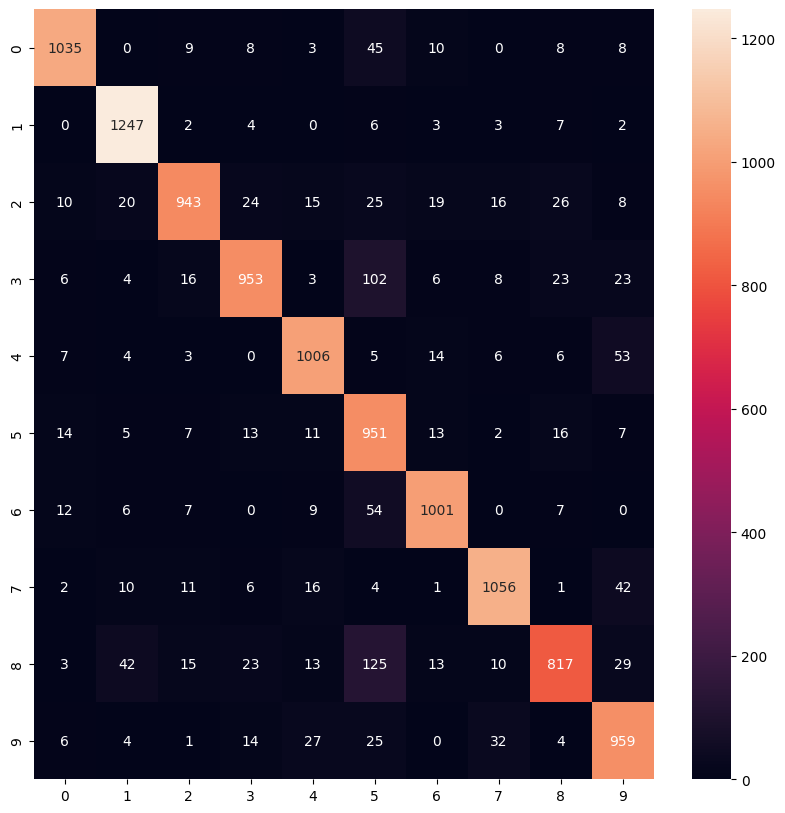

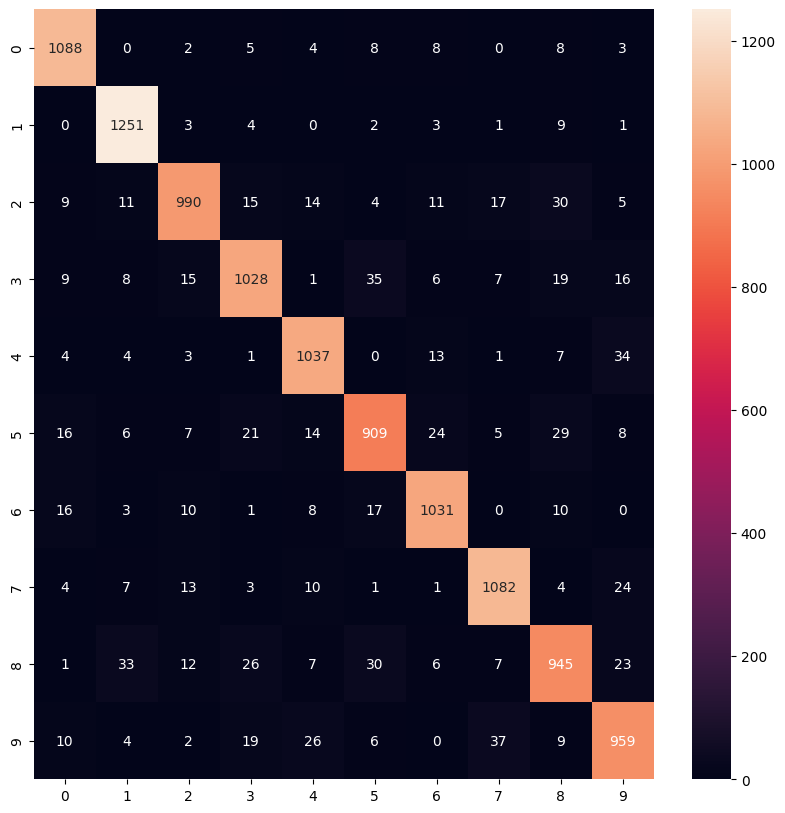

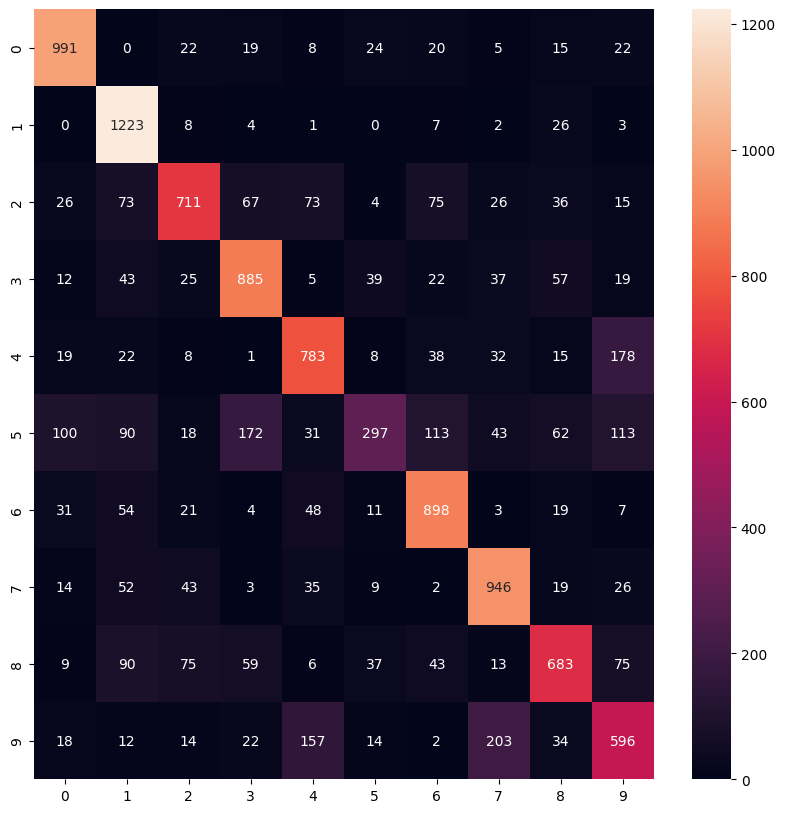

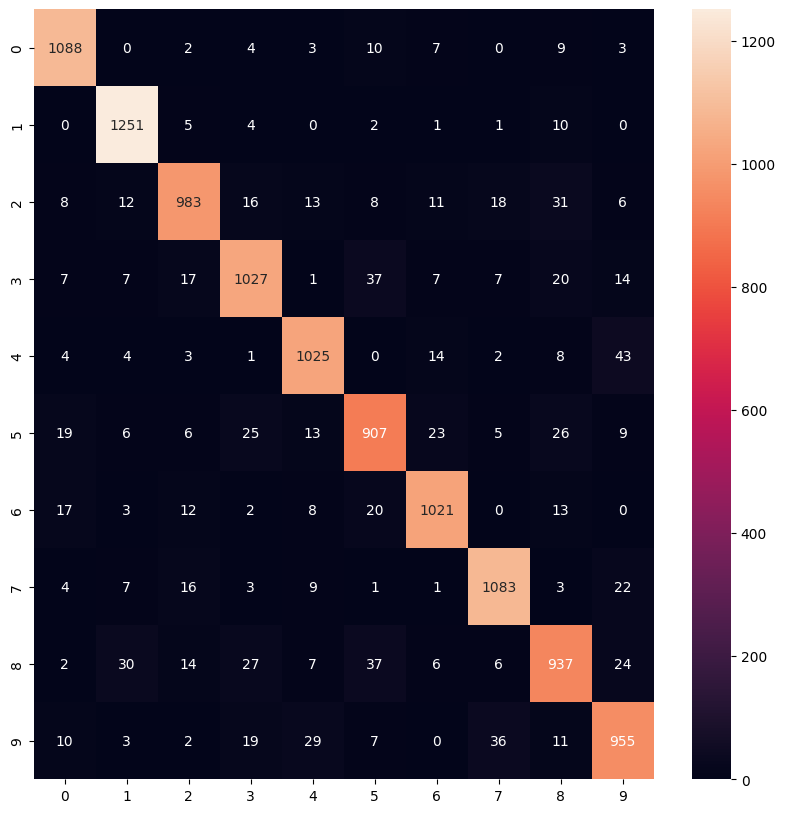

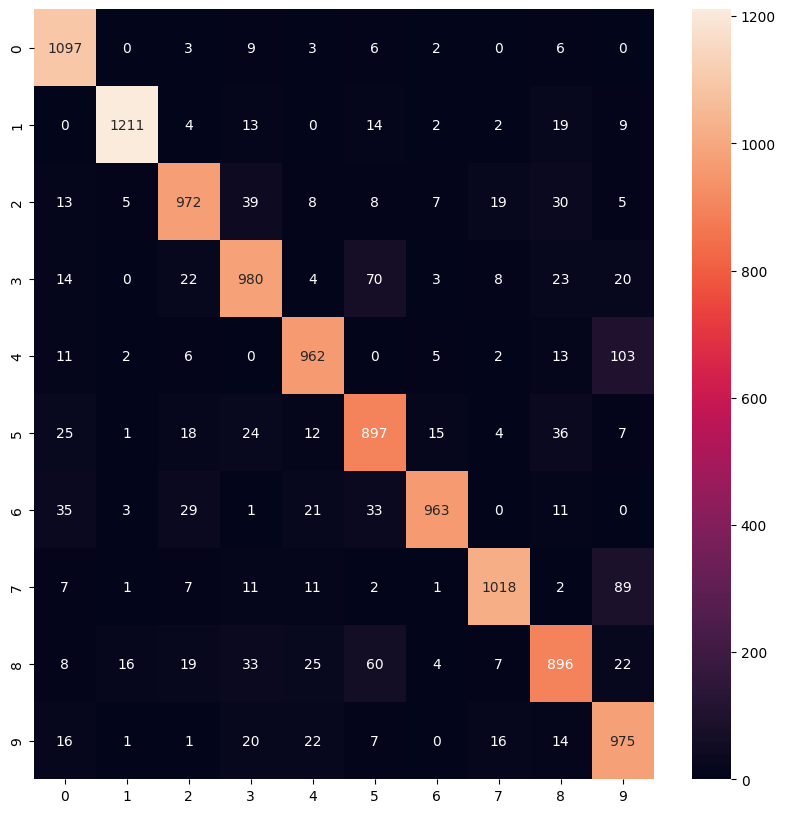

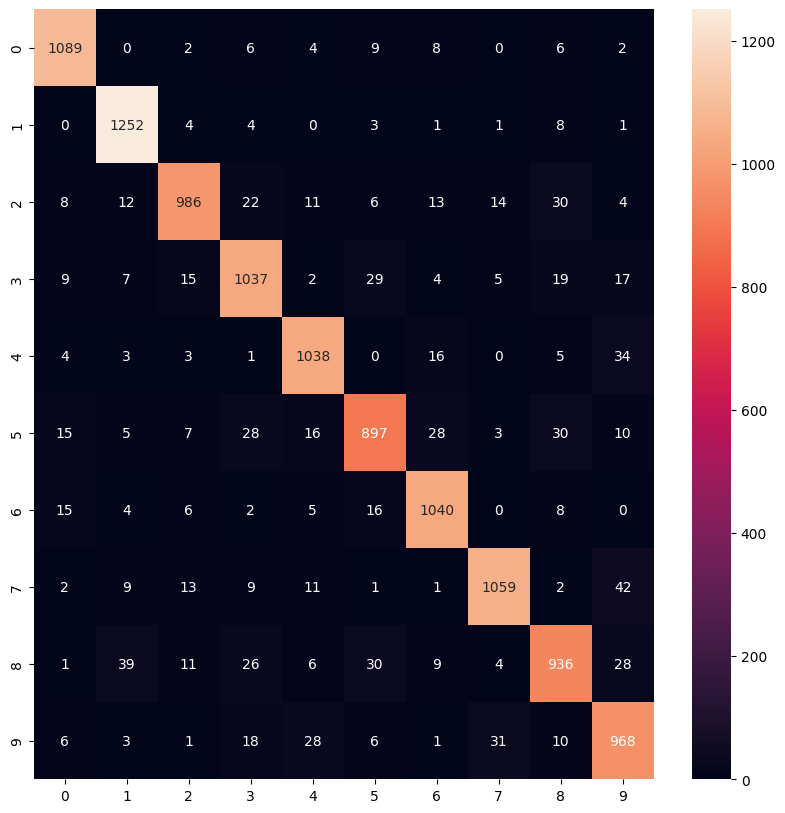

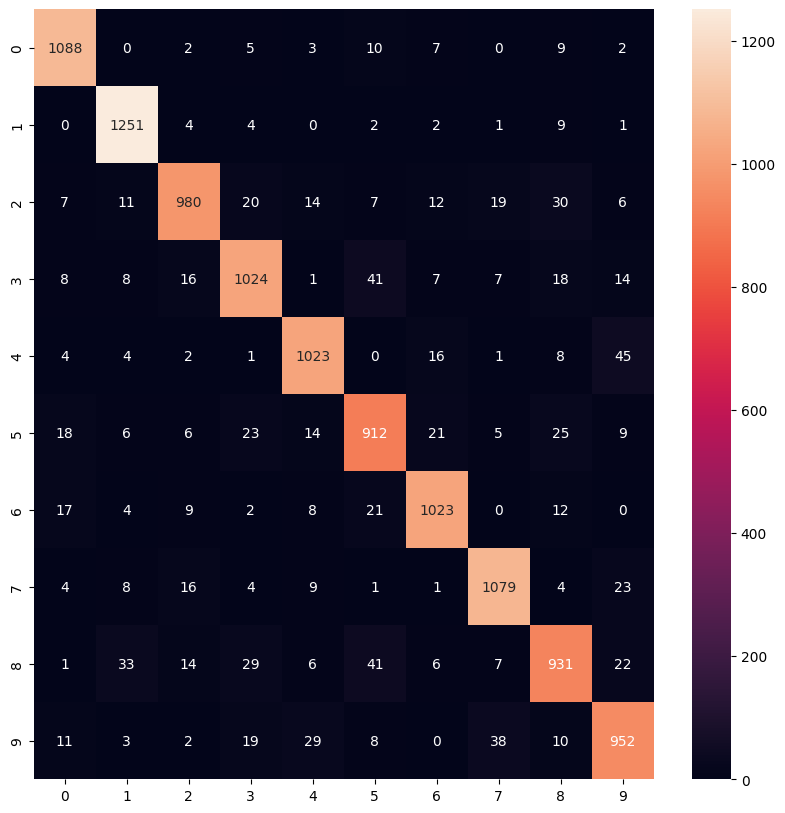

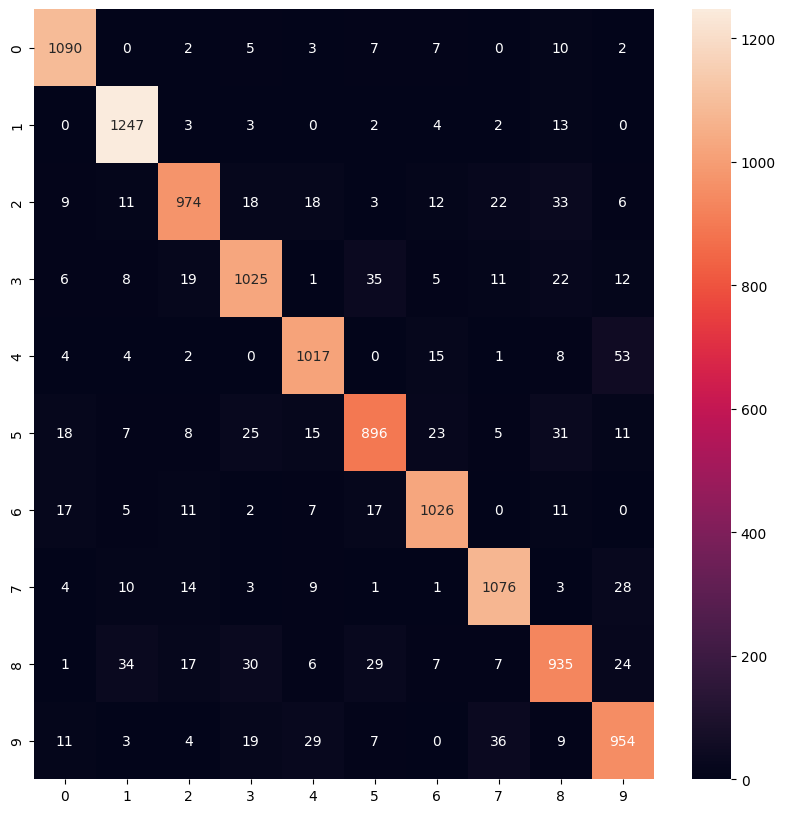

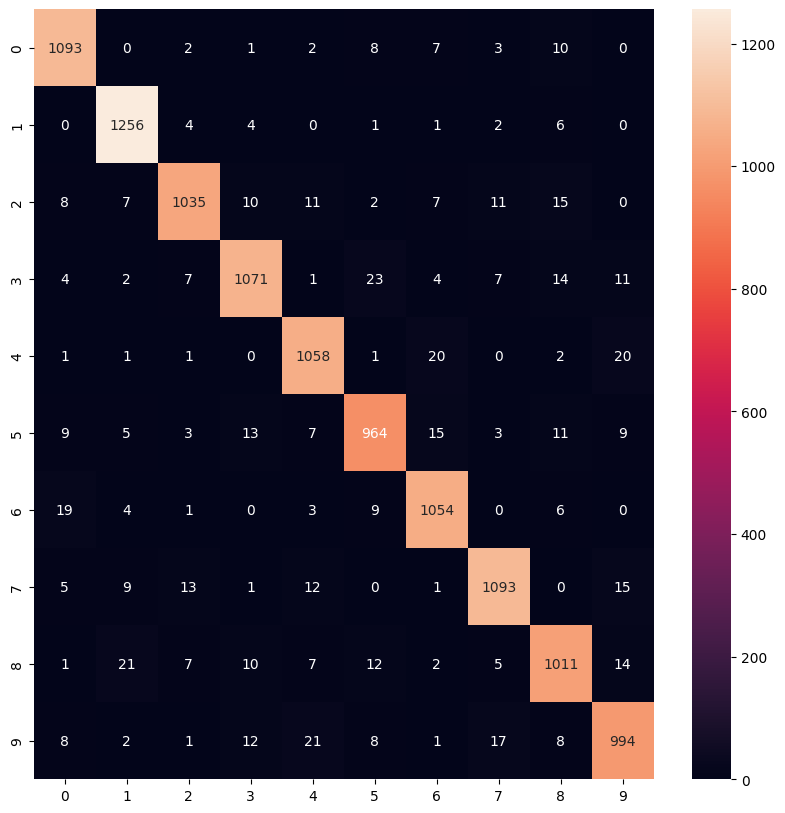

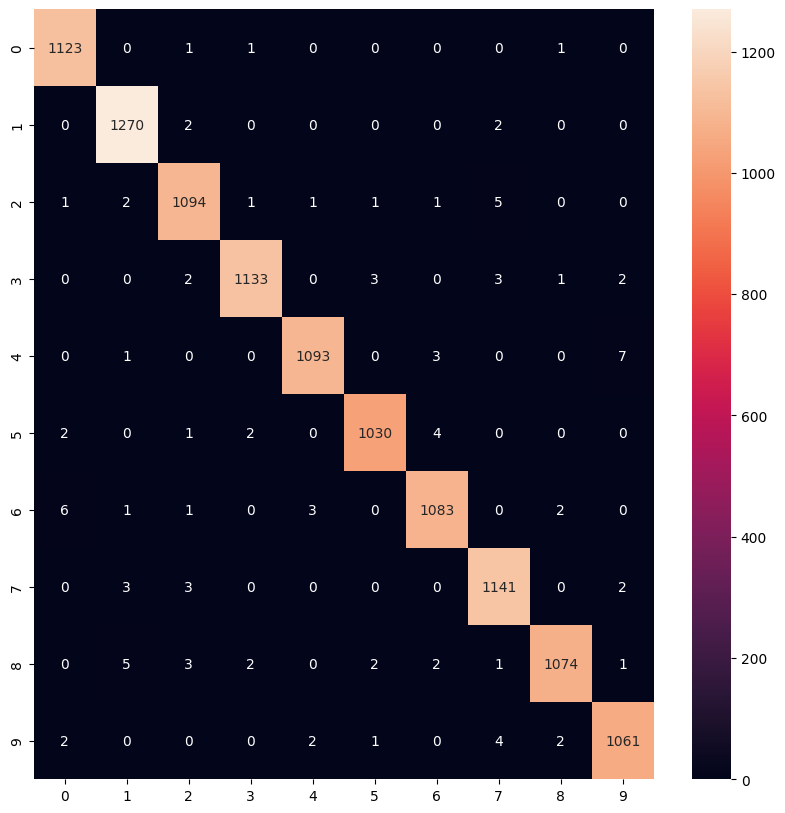

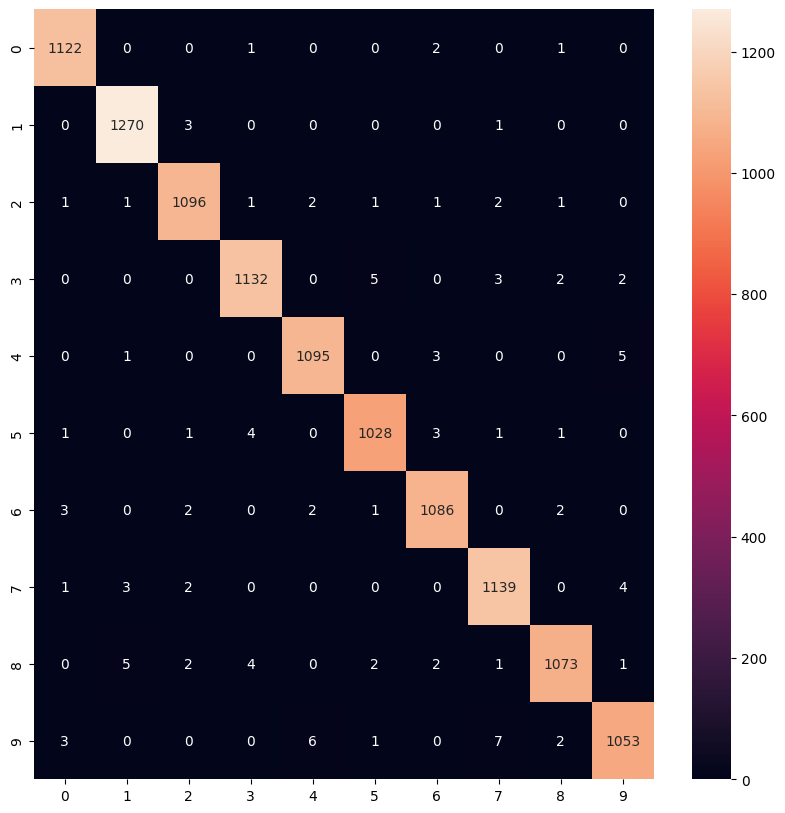

In [29]:
tracker = ExperimentTracker()
run_experiments(experiments, tracker)

# Evaluation

> There are some evaluation insights in the notebook, but for a detailed evaluation, please refer to the [Wandb dashboard](https://wandb.ai/ahmedayman4a77/mnist-exp).

In [30]:
# Display summary table
summary_df = tracker.get_all_summaries()
# remove confusion matrix from summary
display(summary_df.drop(columns=['confusion_matrix']).style.highlight_max(subset=['accuracy']))

,accuracy,avg_inference_time,std_inference_time,total_time,experiment_name
0,0.890000,0.000246,0.000587,396.532794,softmax_lr_1.0
1,0.921429,0.000196,0.000276,389.914764,softmax_lr_0.01
2,0.715446,0.000271,0.000438,407.270516,softmax_lr_0.00001
3,0.917589,0.000248,0.000339,421.689625,softmax_warmup_cosine
4,0.890268,0.000137,0.000165,1471.811282,softmax_batch_1
5,0.919821,0.000206,0.000416,540.018457,softmax_batch_32
6,0.916339,0.000199,0.000147,441.884283,softmax_batch_256
7,0.914286,0.000267,0.000592,463.664805,softmax_with_regularization
8,0.949018,0.000665,0.000227,503.016532,deep_net_nano
9,0.991250,0.001066,0.000647,2812.235097,deep_net_medium


## Model Comparison

### Accuracy Analysis
- Best performing models:
  1. `deep_net_medium`: 99.13% accuracy
  2. `deep_net_large`: 99.05% accuracy
  3. `deep_net_nano`: 94.90% accuracy
- Softmax regression models range between 71-92% accuracy


### Learning Rate Impact
- `softmax_lr_0.01`: Best softmax regression model (92.14% accuracy)
- `softmax_lr_1.0`: Moderate performance (89.00% accuracy)
    - Indicates learning rate is too high
- `softmax_lr_0.00001`: Poor performance (71.54% accuracy)
  - Indicates learning rate is crucial for model convergence
  - Too low learning rate leads to slow convergence


### Batch Size Experiments
- `softmax_batch_32`: Optimal batch size for softmax (91.98% accuracy)
- `softmax_batch_1`: Lowest performance (89.03% accuracy) with much longer training time.
- `softmax_batch_256`: Slightly lower performance (91.63% accuracy)


### Deep Network Insights
- Deeper networks consistently outperform softmax regression
- `deep_net_medium` shows marginal improvement over `deep_net_large`
- Increasing network complexity doesn't always guarantee better performance


### Inference Time Analysis
- Softmax models: ~0.0002-0.0003 seconds per inference
- Deep networks: ~0.0007-0.0015 seconds per inference
- Trade-off between accuracy and computational complexity


### Training Time Observations
- Softmax models: 389-463 seconds
- Deep networks: 503-2887 seconds
- Deep networks require more training time due to increased complexity


### Regularization Impact
- `softmax_with_regularization`: Slight performance reduction
- Suggests careful hyperparameter tuning needed


### Key Takeaways
1. Deep networks superior for MNIST
2. Learning rate critical for model performance
3. Batch size influences training speed and accuracy
4. Computational complexity increases with network depth

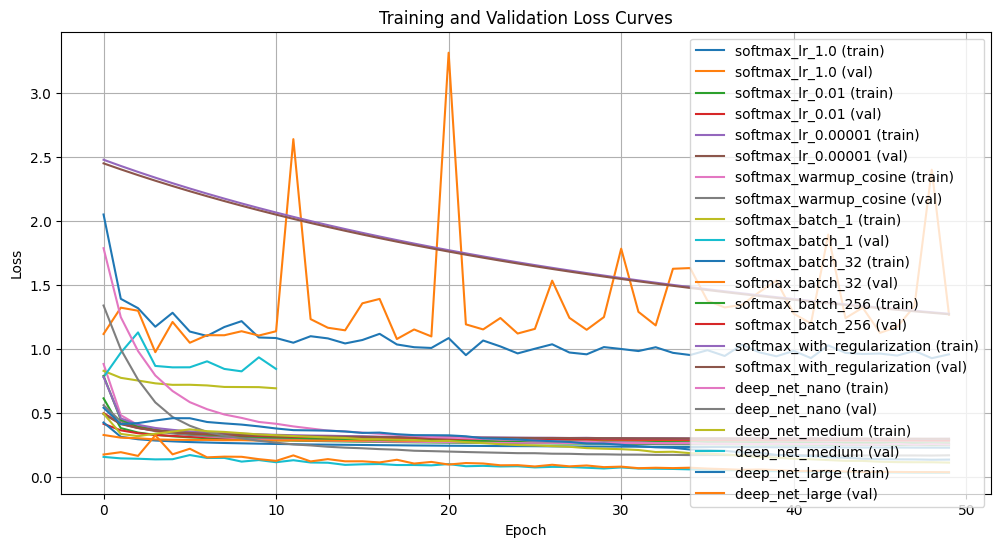

In [31]:
# Plot training curves
fig = tracker.plot_training_curves('loss')
plt.show()

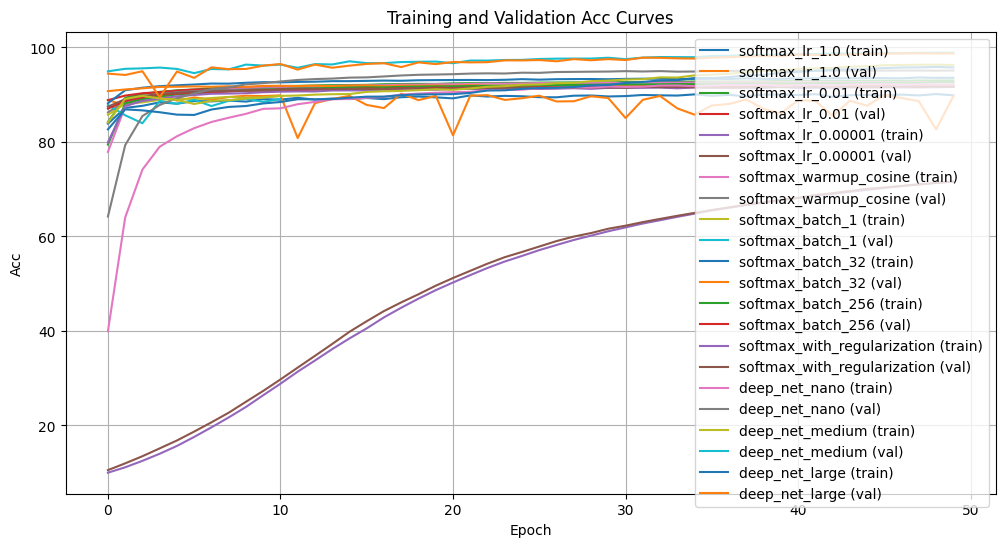

In [32]:
fig = tracker.plot_training_curves('acc')
plt.show()

## Analysis of Training and Validation Curves

### Key Observations

1. Softmax Models:
   - `softmax_lr_1.0`: 
     - Exhibits unstable training behavior with spikes in loss values.
     - Indicates that a high learning rate prevents smooth convergence.
   - `softmax_lr_0.01`:
     - Best performance among softmax models, achieving the lowest validation loss.
     - Shows smoother training and validation curves, suggesting good learning rate.
   - `softmax_lr_0.00001`:
     - High and slow-decreasing loss values throughout training.
     - Reflects that a learning rate too small leads to slow or incomplete convergence.
   - Batch Size Impact:
     - Smaller batches (e.g., `softmax_batch_1`) result in noisier curves due to less accurate gradient estimates.
     - Larger batches (e.g., `softmax_batch_256`) stabilize the curves but sacrifice slight accuracy.

2. Deep Networks:
   - Models like `deep_net_medium` and `deep_net_large` consistently show lower training and validation losses compared to softmax models.
   - Network Size vs. Convergence:
     - Smaller networks like `deep_net_nano` converge faster but reach lower accuracy values.
     - Larger networks take longer to converge but achieve better accuracy.

3. Regularization:
   - Regularization models show slightly elevated loss values compared to unregularized models, indicating the penalty imposed by regularization to prevent overfitting.

4. Cosine Warmup Learning Rate:
   - The `softmax_warmup_cosine` curve demonstrates a gradual reduction in loss, indicating effective scheduling for stable convergence.

### Insights from the Curves
1. Learning Rate:
   - Proper tuning is critical, as seen in the superior performance of `softmax_lr_0.01` compared to other learning rate configurations.
   - Extremely low or high learning rates lead to poor convergence and unstable training.

2. Model Complexity:
   - Deep networks outperform softmax models in terms of achieving lower loss and higher accuracy.
   - Increasing network complexity doesn't always yield significant performance improvement (e.g., `deep_net_medium` vs. `deep_net_large`).

3. Batch Size:
   - Optimal batch sizes balance stability and accuracy, as evidenced by the superior performance of `softmax_batch_32`.

4. Overfitting Indicators:
   - Narrow gaps between training and validation loss curves indicate better generalization, as seen in `deep_net_medium`.

5. Stability and Convergence:
   - Models with smoother loss curves (e.g., `deep_net_medium` and `softmax_lr_0.01`) are more reliable and generalize better than those with fluctuating loss patterns.


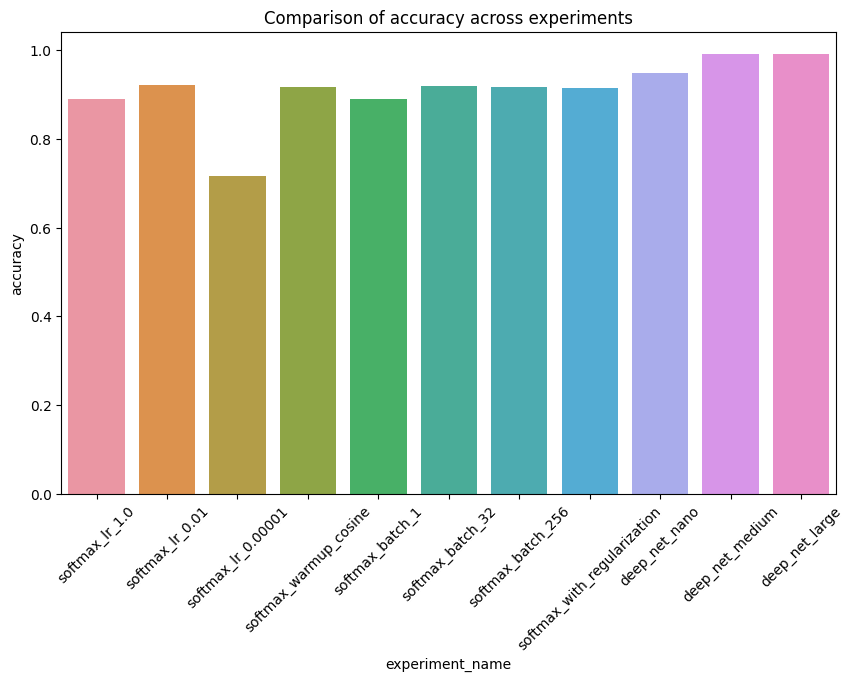

In [33]:
# Compare final metrics on test set
fig = tracker.plot_experiment_comparison('accuracy')
plt.show()

In [34]:
# Export results
summary_df.to_csv('experiment_results.csv')

In [40]:
# Detailed view of specific experiment
exp_df = tracker.get_experiment_df('deep_net_medium')
display(exp_df)

,epoch,train_loss,train_acc,val_loss,val_acc,learning_rate,epoch_time
0,0,0.497291,84.109375,0.159649,94.942857,0.004667,55.996205
1,1,0.338992,89.111607,0.148122,95.471429,0.006000,55.830900
2,2,0.321408,89.743304,0.145222,95.571429,0.007333,55.088057
3,3,0.340370,89.200893,0.140176,95.735714,0.008667,55.864079
4,4,0.356799,88.883929,0.141500,95.450000,0.010000,54.722889
5,5,0.374468,88.024554,0.174082,94.557143,0.009988,55.230920
6,6,0.360194,88.705357,0.151320,95.435714,0.009951,55.298661
7,7,0.354372,88.816964,0.151848,95.357143,0.009891,55.741643
8,8,0.344741,89.189732,0.122903,96.364286,0.009807,55.441713
9,9,0.334645,89.392857,0.134888,96.164286,0.009699,54.673023


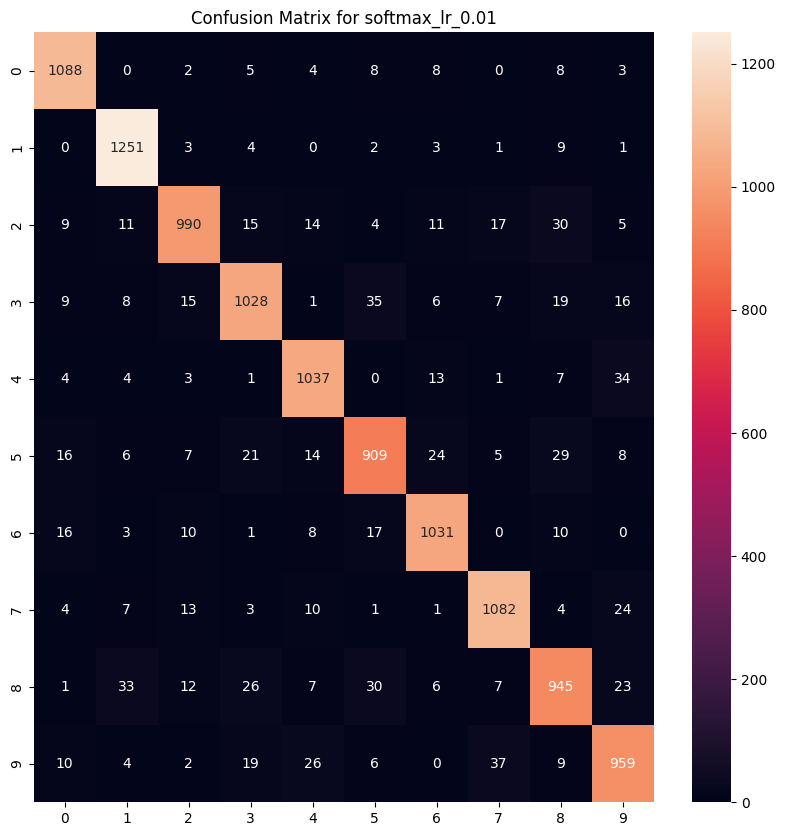

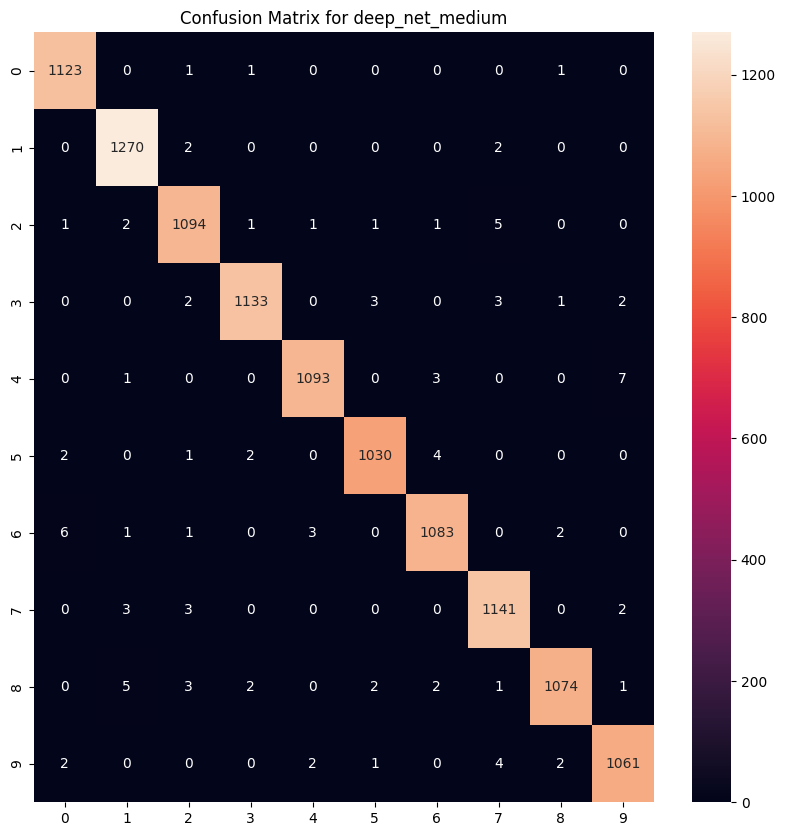

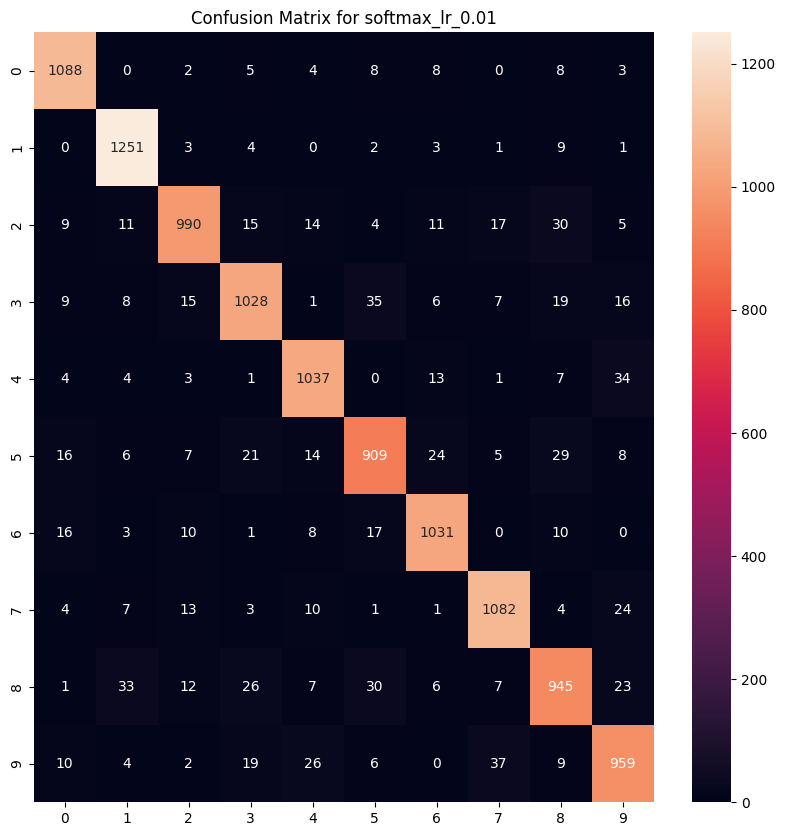

In [41]:
tracker.plot_confusion_matrix('deep_net_medium')
tracker.plot_confusion_matrix('softmax_lr_0.01')

### Confusion Matrix Analysis
* The confusion matrix for the softmax regression model with the learning rate of 0.01 shows that the model is performing well, with relatively low misclassifications. However, it still struggles with certain digits, especially those that are visually similar e.g., 3vs5 or 4vs9. 

* The confusion matrix of the deep neural network reveals an exceptionally high accuracy rate, with very few misclassifications. Most of the confusion happens between digits that are similar, like 4 vs 9, but these are minimal. 

    The deep neural network shows that it can effectively differentiate between a wide range of digit variations, which is reflected in the low false positive and false negative rates.

### Misclassification Analysis on Deep Neural Network

We can see from the sample of the miscalssified images that the deep neural network is struggling with digits that are not clearly written or are ambiguous. This is expected as even humans can struggle with these images.


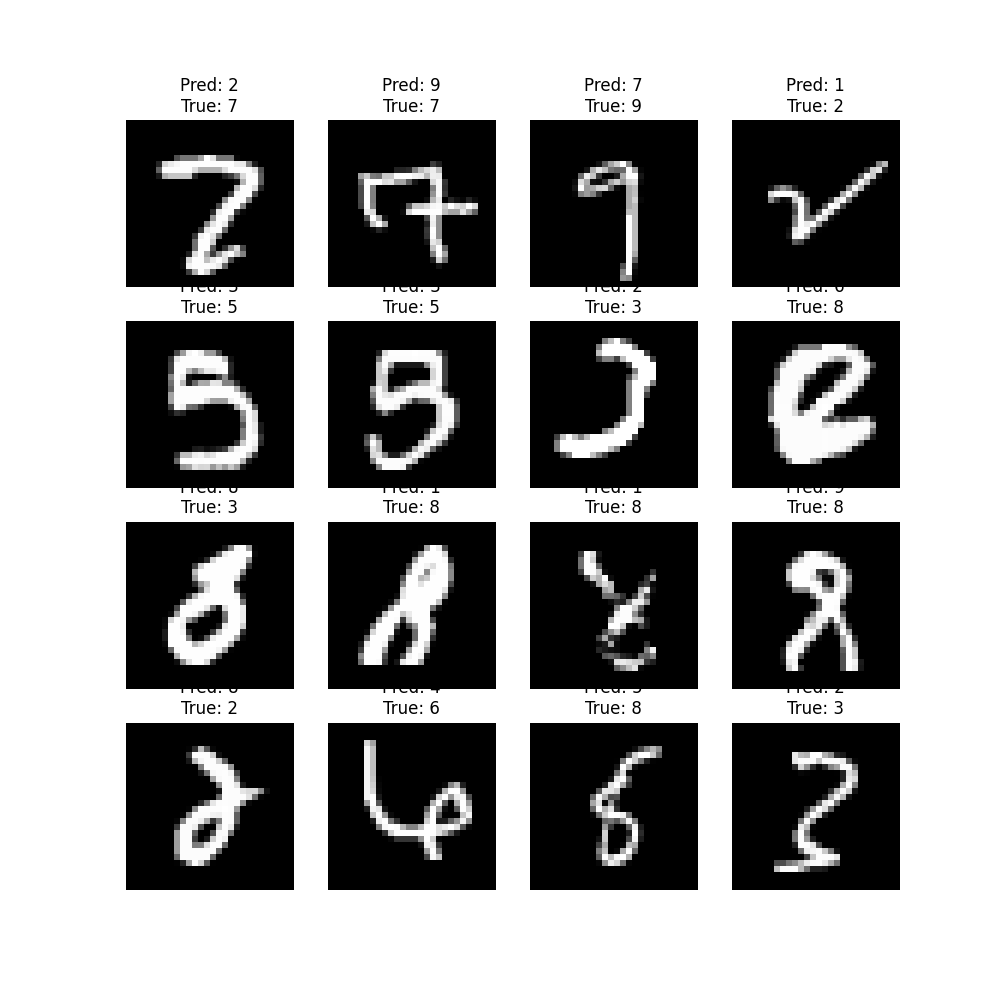
    
     